In [1]:
import pandas as pd
import numpy as np
from pvlib import location, irradiance, temperature, pvsystem,solarposition
import matplotlib.pyplot as plt
from random import seed
from itertools import product
from sandiapv_energy_prediction import *
from scipy.integrate import trapezoid
from scipy.stats import truncnorm



C:\Users\denni\AppData\Local\Temp\ipykernel_26768\2318648313.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_pv_system(panel):
    """ Retrieves and configures a PVSystem object based on the panel type and parameters. """

    module_specs = {
    'monocrystalline': {'pdc0': 220, 'gamma_pdc': -0.0045},
    'polycrystalline': {'pdc0': 200, 'gamma_pdc': -0.005},
    'thin-film': {'pdc0': 180, 'gamma_pdc': -0.002},
    'bifacial': {'pdc0': 210, 'gamma_pdc': -0.004}    
    } 
    
    module_parameters = module_specs[panel['module_type']]
    mount = pvsystem.FixedMount(panel['tilt'], panel['azimuth'],)
    inverter_parameters = {'pdc0': 5000, 'eta_inv_nom': 0.96}
    array_one = (pvsystem.Array( mount=mount, 
                                module_parameters=module_parameters,
                                temperature_model_parameters= panel['temperature']
                                ))
    return pvsystem.PVSystem(name = 'system1',
                            arrays =array_one,
                            inverter =inverter_parameters,                           
                            )

def simulate_pv_output(system, weather_data, location):
    """ Simulate daily PV output for all arrays in the system. """
    #solar_position = location.get_solarposition(weather_data.index)
    solar_position = location.get_solarposition(weather_data.index, location.latitude, location.longitude)
    #print(len(np.unique(solar_position['apparent_zenith'].values)),np.max(solar_position['azimuth'].values))
    #print(np.max(solarposition.get_solarposition(weather_data.index, location.latitude, location.longitude)))
    temp_air = weather_data['temp_air']
    wind_speed = weather_data['wind_speed']
    
    # Initialize an empty DataFrame to store the output for each array
    output_data = pd.DataFrame(index=weather_data.index)
    
    # Simulate output for each array in the system
    for array in system.arrays:
        poa_irrad = irradiance.get_total_irradiance(array.mount.surface_tilt, array.mount.surface_azimuth,
                                                    solar_position['apparent_zenith'], solar_position['azimuth'],
                                                    weather_data['dni'], weather_data['temp_air'], weather_data['dhi'])
        # Calculate cell temperature
        cell_temperature = temperature.sapm_cell(poa_irrad['poa_global'], temp_air, wind_speed,
                                                  **array.temperature_model_parameters)
        single_array_system = pvsystem.PVSystem(
                             name=system.name,
                            arrays=[system.arrays[0]],
                            inverter=system.inverter,)
        # Calculate DC output for the current array
        dc_output = single_array_system.pvwatts_dc(poa_irrad['poa_global'], cell_temperature)
        
        # Store the DC output in the output_data DataFrame
        output_data[array.name] = dc_output
    
    return output_data

In [3]:
weather_data =  pd.read_csv('energy_data/result.csv')

weather_data = weather_data.drop('W.mean_value',axis=1)

weather_data.index = pd.to_datetime(weather_data['time'], utc=True)
weather_data.rename(columns={'T': 'temp_air', 'FH': 'wind_speed'}, inplace=True)
#print(weather_data.columns)
#print(weather_data.shape)
weather_data.tail()

# Define your location (Eindhoven)
latitude, longitude, tz = 51.43, 5.48, 'Europe/Amsterdam'
site_location = location.Location(latitude, longitude, tz)

# Calculate solar position
solar_position = site_location.get_solarposition(weather_data.index)
print(np.unique(solar_position['elevation']))
# Filter out nighttime data
weather_data_daily = weather_data[solar_position['elevation'] > 0]

# Now you can check the filtered dataset
print(weather_data_daily.columns)
print(weather_data_daily.shape)
print(weather_data_daily.tail())

[-61.65433515 -61.65060019 -61.64995832 ...  61.73832837  61.73887968
  61.74207716]
Index(['time', 'Q', 'temp_air', 'wind_speed', 'dni', 'dhi'], dtype='object')
(4405, 6)
                                                time           Q  temp_air  \
time                                                                         
2023-12-31 11:00:00+00:00  2023-12-31 11:00:00+00:00  116.666667       8.7   
2023-12-31 12:00:00+00:00  2023-12-31 12:00:00+00:00  136.111111       8.9   
2023-12-31 13:00:00+00:00  2023-12-31 13:00:00+00:00  113.888889       9.2   
2023-12-31 14:00:00+00:00  2023-12-31 14:00:00+00:00   30.555556       9.6   
2023-12-31 15:00:00+00:00  2023-12-31 15:00:00+00:00    5.555556       9.4   

                           wind_speed        dni         dhi  
time                                                          
2023-12-31 11:00:00+00:00        90.0  30.650095  108.786827  
2023-12-31 12:00:00+00:00        90.0  57.446371  120.914873  
2023-12-31 13:00:00+00:00    

In [4]:
def sensitivity_analysis(weather_data, altitude, tilt_range, azimuth_range, module_types,temperature_params):
    results = []
    for tilt, azimuth, module_type,temp,altitude in product(tilt_range, azimuth_range, module_types,temperature_params,altitude): 
        site_location = location.Location(latitude=51.43, longitude=5.48, altitude=altitude, tz='Europe/Amsterdam')         
        #51.43
        panel = {'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'altitude':altitude,'temperature':{'a': temp[0], 'b': temp[1], 'deltaT': temp[2]} }
        system = get_pv_system(panel)
        output = simulate_pv_output(system, weather_data, site_location)
        #print(panel,output.mean().mean())
        results.append({'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'altitude':altitude,'temperature':{'a': temp[0], 'b':temp[1], 'deltaT': temp[2]} , 'output': output.mean().mean()})
    return pd.DataFrame(results)

In [5]:
 # Define ranges for parameters
tilt_range = np.linspace(0,90, 10)  
azimuth_range = np.linspace(0, 360, 10)  
altitude = np.linspace(1,1,1)
module_types = ['monocrystalline','polycrystalline', 'thin-film', 'bifacial']
temperature_params = [[-3.47, -0.0594, 3],[-2.98, -0.0471, 1],]#[-3.56, -0.075, 3],[-2.81, -0.0455, 0]]

try:
    sa_results = pd.read('energy_data/sensitivity_analysis_results.csv')
except: 
    # Perform sensitivity analysis
    sa_results = sensitivity_analysis(weather_data_daily, altitude, tilt_range, azimuth_range, module_types,temperature_params)
    
    # Save results to CSV
    sa_results.to_csv('energy_data/sensitivity_analysis_results.csv', index=False)


In [6]:
sa_results.head()
#print('rows:',len(sa_results['tilt']))

,tilt,azimuth,module_type,altitude,temperature,output
0,0.0,0.0,monocrystalline,1.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",56.698258
1,0.0,0.0,monocrystalline,1.0,"{'a': -2.98, 'b': -0.0471, 'deltaT': 1}",56.329403
2,0.0,0.0,polycrystalline,1.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",51.635053
3,0.0,0.0,polycrystalline,1.0,"{'a': -2.98, 'b': -0.0471, 'deltaT': 1}",51.262473
4,0.0,0.0,thin-film,1.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",45.979161


0    {'a': -3.47, 'b': -0.0594, 'deltaT': 3}
1    {'a': -2.98, 'b': -0.0471, 'deltaT': 1}
Name: temperature, dtype: object


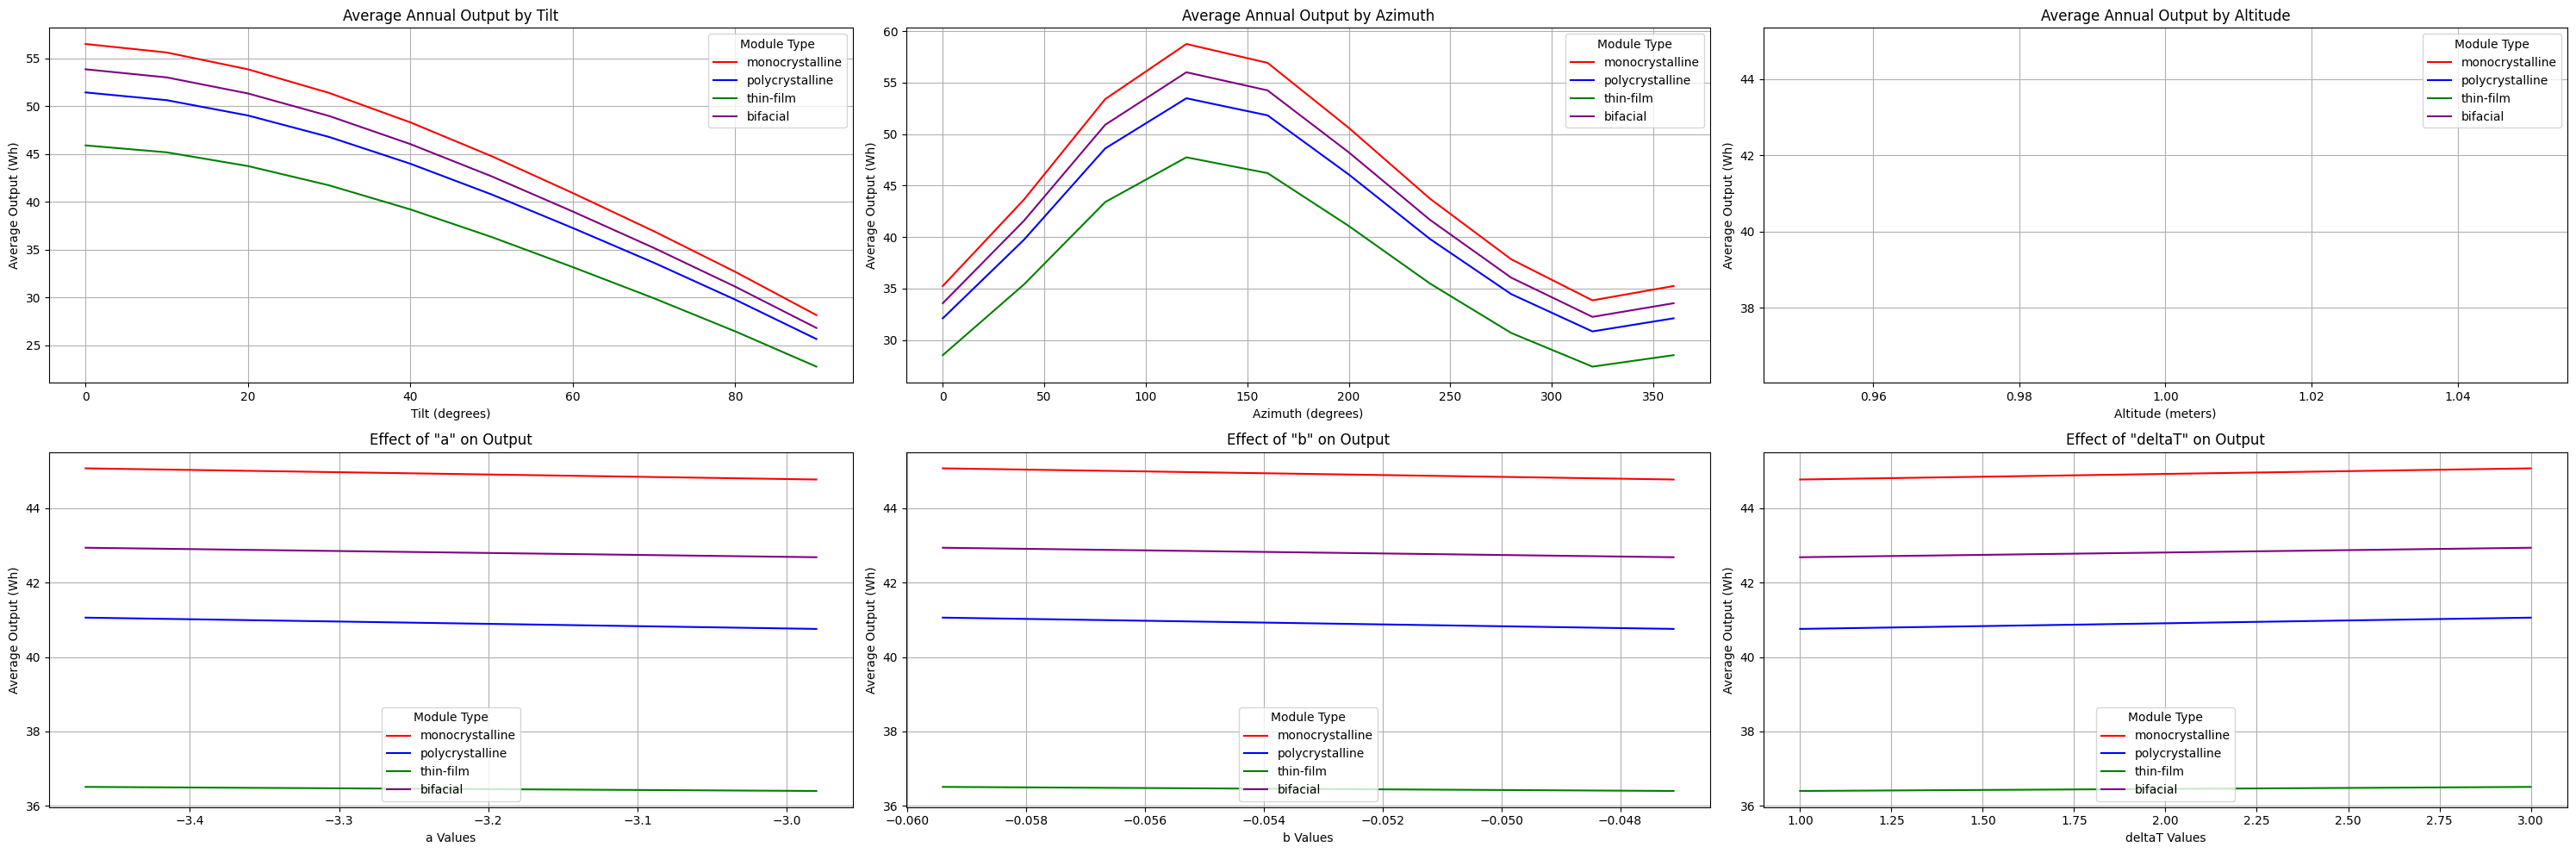

In [7]:
# Assume 'sa_results' is your DataFrame containing the results of the sensitivity analysis
module_types = ['monocrystalline', 'polycrystalline', 'thin-film', 'bifacial']
colors = ['red', 'blue', 'green', 'purple']  #

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))

# Tilt Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    tilt_agg = filtered_data.groupby('tilt')['output'].mean()
    axes[0,0].plot(tilt_agg.index, tilt_agg.values, label=f'{module_type}', color=color)
axes[0,0].set_title('Average Annual Output by Tilt')
axes[0,0].set_xlabel('Tilt (degrees)')
axes[0,0].set_ylabel('Average Output (Wh)')
axes[0,0].legend(title='Module Type')
axes[0,0].grid(True)

# Azimuth Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    azimuth_agg = filtered_data.groupby('azimuth')['output'].mean()
    axes[0,1].plot(azimuth_agg.index, azimuth_agg.values, label=f'{module_type}', color=color)
axes[0,1].set_title('Average Annual Output by Azimuth')
axes[0,1].set_xlabel('Azimuth (degrees)')
axes[0,1].set_ylabel('Average Output (Wh)')
axes[0,1].legend(title='Module Type')
axes[0,1].grid(True)

# Empty third column in the first row
# Azimuth Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    azimuth_agg = filtered_data.groupby('altitude')['output'].mean()
    axes[0,2].plot(azimuth_agg.index, azimuth_agg.values, label=f'{module_type}', color=color)
axes[0,2].set_title('Average Annual Output by Altitude')
axes[0,2].set_xlabel('Altitude (meters)')
axes[0,2].set_ylabel('Average Output (Wh)')
axes[0,2].legend(title='Module Type')
axes[0,2].grid(True)

# Temperature Effects Plot, now in the second row
temp_params = sa_results['temperature'].drop_duplicates().reset_index(drop=True)
temp_colors = ['red', 'blue', 'green', 'purple'][:len(temp_params)]
print(temp_params)


temp_df = sa_results['temperature'].apply(pd.Series)
sa_results_expanded = pd.concat([sa_results, temp_df], axis=1)

# Plotting the effects of each temperature parameter 'a', 'b', 'deltaT'
parameters = ['a', 'b', 'deltaT']
titles = ['Effect of "a" on Output', 'Effect of "b" on Output', 'Effect of "deltaT" on Output']
x_labels = ['a Values', 'b Values', 'deltaT Values']

for i, param in enumerate(parameters):
    for color, module_type in zip(colors, module_types):
        # Filter data for each module type and aggregate by parameter
        filtered_data = sa_results_expanded[sa_results_expanded['module_type'] == module_type]
        param_agg = filtered_data.groupby(param)['output'].mean()
        
        axes[1,i].plot(param_agg.index, param_agg.values, label=f'{module_type}', color=color)
        axes[1,i].set_title(titles[i])
        axes[1,i].set_xlabel(x_labels[i])
        axes[1,i].set_ylabel('Average Output (Wh)')
        axes[1,i].legend(title='Module Type')
        axes[1,i].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

## 2) Generate Dataset

In [8]:
# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to fit Gaussian to daily data
def fit_gaussian_to_daily_data(hourly_data):
    x_numeric = np.arange(len(hourly_data))
    #print(hourly_data.values)
    #hourly_data = hourly_data.values
    #print(hourly_data)
    #print(hourly_data)
    try:
        # Improved initial guesses and increase maxfev
        p0 = [max(hourly_data), np.argmax(hourly_data), len(hourly_data) / 2]  # Better estimate of std deviation
        popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
    except Exception as e:
        #print(f"Error in Gaussian fit: {e}")
        popt = None
    return popt



In [19]:
from scipy.stats import truncnorm

def get_truncated_normal(mean, std, lower_bound, upper_bound, n_samples):
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(n_samples)

def generate_dataset(days_per_pv_panel,weather_data, site_location,module_types,module_probs, temperature_params,n_samples,tilt_mean,tilt_std,azimuth_mean,azimuth_std):
    results = []
    delta_AUC = []
    counter = 0
    iteration =0 

    tilts = get_truncated_normal(tilt_mean, tilt_std, 0, 90, n_samples)
    azimuths = get_truncated_normal(azimuth_mean, azimuth_std, 0, 360, n_samples)
    modules = np.random.choice(module_types, n_samples, p=module_probs)

    for tilt, azimuth, module_type in zip(tilts, azimuths, modules):          
        panel = {'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'temperature':{'a': temperature_params[0], 'b': temperature_params[1], 'deltaT': temperature_params[2]} }
        system = get_pv_system(panel)
        output = simulate_pv_output(system, weather_data, site_location)
        counter += 1 
        #print(counter)
        
        start_day = np.random.randint(0,365-days_per_pv_panel)
        #print(start_day)
        for day in range(days_per_pv_panel):
            iteration +=1
            #print(iteration)
            start_idx = (start_day*24) + day * 24
            end_idx = (start_day*24)+ (day + 1) * 24

            daily_data = output.iloc[start_idx:end_idx]
            daily_weather_data = weather_data.iloc[start_idx:end_idx]
            
            popt = fit_gaussian_to_daily_data(daily_data.values.flatten())
            #print(popt)
            if popt is not None:
                x_dense = np.linspace(0, 23, 500)  
                gaussian_curve = gaussian(x_dense, *popt)
                
                # Calculate the area under the Gaussian curve
                area_gaussian = trapezoid(gaussian_curve, dx=x_dense[1]-x_dense[0])

                # Calculate the area under the original daily mean data
                area_original = trapezoid(daily_data, dx=1) 
                delta_AUC.append(area_original/area_gaussian)
                
                #Extracting hourly weather data lists
                daily_weather = {
                'temperature_sequence': list(daily_weather_data['temp_air']),
                'wind_speed_sequence': list(daily_weather_data['wind_speed']),
                'dni_sequence': list(daily_weather_data['dni']),
                'dhi_sequence': list(daily_weather_data['dhi']),
                'global_irradiance_sequence': list(daily_weather_data['Q'])
                 }
                results.append({
                    'module_type': module_type,
                    'tilt': tilt,
                    'azimuth': azimuth,
                    'gaussian_params': popt,
                    'day': int(start_idx/24),
                    'energy_data':daily_data.sum().sum(),
                    **daily_weather,                 
                })
    #print(np.mean(delta_AUC.flatten()))
    return pd.DataFrame(results)

days_per_pv_panel = 25
n_samples = 500
tilt_mean = 51
tilt_std = 30
azimuth_mean = 100
azimuth_std = 180
module_types = ['monocrystalline', 'polycrystalline']
module_probs = [0.7, 0.3]
temperature_params = [-2.81, -0.0455, 0] #glass/polymer, Insulated Back
site_location = location.Location(latitude=51.44, longitude=5.47, altitude=34, tz='Europe/Amsterdam')

# Perform sensitivity analysis
sa_results = generate_dataset(days_per_pv_panel,weather_data, site_location,module_types,module_probs, temperature_params,n_samples,tilt_mean,tilt_std,azimuth_mean,azimuth_std)
    
# Save results to CSV
sa_results.to_csv('energy_data/dataset_to_train_model.csv', index=False)


C:\Users\denni\AppData\Local\Temp\ipykernel_26768\1837351990.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
C:\Users\denni\AppData\Local\Temp\ipykernel_26768\1837351990.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
C:\Users\denni\AppData\Local\Temp\ipykernel_26768\1837351990.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
C:\Users\denni\AppData\Local\Temp\ipykernel_26768\1837351990.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
C:\Users\denni\AppData\Local\Temp\ipykernel_26768\1837351990.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ =

## 3) Plot dataset to verify 

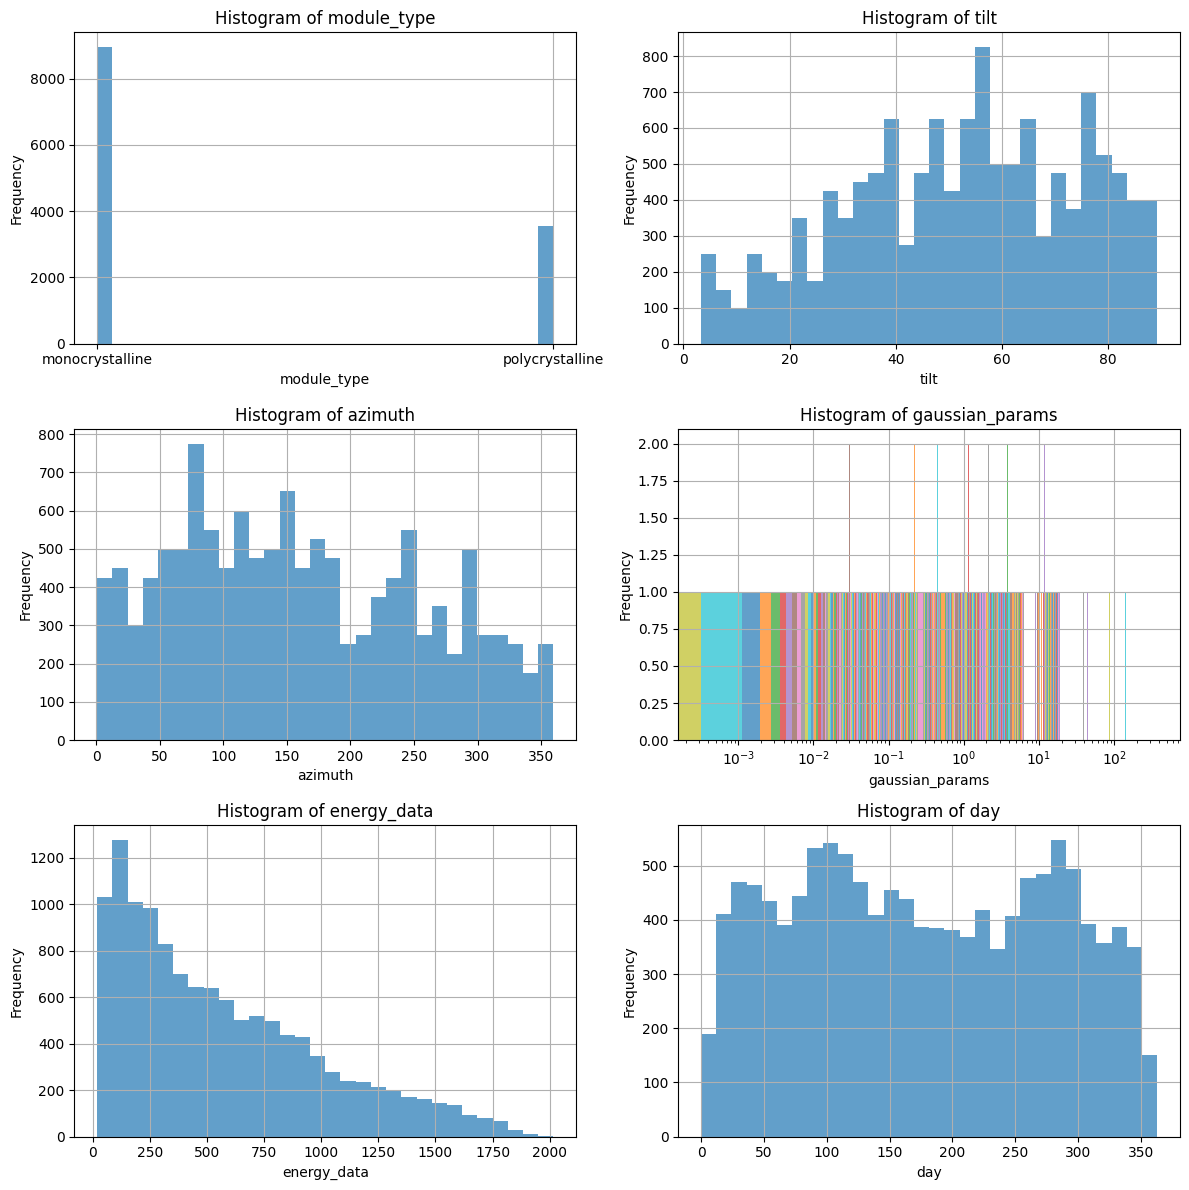

In [20]:
columns =[ 'module_type','tilt','azimuth','gaussian_params','energy_data','day']
num_columns = len(columns)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))  
axes = axes.flatten()  

for i, column in enumerate(columns):
    sa_results[column].hist(ax=axes[i], bins=30, alpha=0.7)  
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    if column == 'gaussian_params':
        axes[i].set_xscale('log')  


# If the number of columns is odd, hide the last subplot (if unused)
if num_columns % 2 != 0:
    fig.delaxes(axes[-1])

fig.tight_layout()
plt.show()